In [42]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

from oneshot0script import GaussianActor, Simulation

In [2]:
training_timestamps = ["20210908093749", "20210908094007", "20210908094044"]

In [3]:
histories = []
for timestamp in training_timestamps:
    with open(f"models/onestep-history-{timestamp}.pkl", "rb") as f:
        history = pickle.load(f)
        histories.append(history)

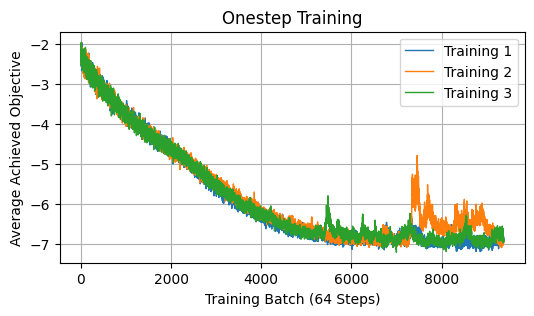

In [28]:
plt.figure(figsize=(6,3))
for i, history in enumerate(histories):
    plt.plot([record["objective"] for record in history], lw=1, label=f"Training {i+1}")
plt.title("Onestep Training")
plt.xlabel("Training Batch (64 Steps)")
plt.ylabel("Average Achieved Objective")
plt.grid()
plt.legend()
plt.show()

In [35]:
models = [torch.load(f"models/onestep-model-{timestamp}.pkl") for timestamp in training_timestamps]

In [37]:
simulation = Simulation()

In [73]:
observation = simulation.reset()

In [74]:
observation_factor = np.concatenate([
    simulation.actuator_space.high,
    simulation.goal_space.high,
    simulation.goal_space.high
])

normalized_observation = observation / observation_factor
normalized_observation = torch.tensor(normalized_observation, dtype=torch.float32)
unsqueezed_observation = normalized_observation.unsqueeze(0)

unsqueezed_actuators = models[0](unsqueezed_observation).sample()

normalized_actuators = unsqueezed_actuators.squeeze()
actuators = normalized_actuators.detach().numpy() * simulation.actuator_space.high

actuators

array([ 7.6872520e+00, -1.5624370e+01,  1.5576981e+01,  9.5876778e-04,
       -4.1280864e-03], dtype=float32)

Desired: [-0.00197863  0.00134199  0.00023895  0.00027946]


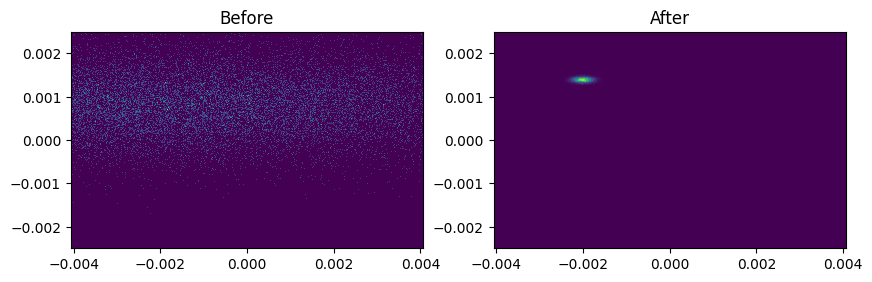

In [75]:
print("Desired:", simulation.desired)

screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
plt.title("Before")

simulation.track(actuators)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
plt.title("After")

plt.show()